# Caso de Uso: Detección de fraude en consumo energético

El fraude energético es un problema significativo para las compañías de electricidad, ya que genera pérdidas económicas, afecta la estabilidad del sistema y puede derivar en riesgos de seguridad. Muchas de estas irregularidades ocurren cuando los clientes manipulan sus medidores de electricidad o reportan consumos menores a los reales para pagar facturas más bajas.

En este contexto, se requiere desarrollar un modelo de detección de fraude que permita identificar clientes con patrones de consumo anómalos y optimizar las inspecciones comerciales. Esto permitirá reducir costos operativos y mejorar la eficiencia en la identificación de fraudes.

## Objetivos

Objetivo del análisis El objetivo de este análisis es detectar clientes con alta probabilidad de fraude utilizando datos de consumo energético y características de facturación. Para ello, se analizarán patrones en los niveles de consumo, estados de los medidores y diferencias en las lecturas de los contadores. Se explorarán anomalías y se evaluará si ciertos comportamientos están asociados a casos de fraude.

Los pasos clave del análisis incluyen:
- Exploración de datos para entender patrones de consumo.
- Identificación de valores atípicos en el consumo y diferencias de medición.
- Análisis de fraude (target) y su relación con las variables disponibles.
- Desarrollo de un modelo predictivo para clasificar clientes fraudulentos.

## Descripción de los datasets

1. **Dataset "clients1_3.csv"**: Contiene información sobre 135,493 clientes con las siguientes variables:
- disrict: Código numérico del distrito (Integer)
- client_id: Identificador único del cliente (String)
- client_catg: Categoría del cliente (Integer)
- region: Código de región geográfica (Integer)
- creation_date: Fecha de alta del cliente (String, formato DD/MM/YYYY)
- target: Variable objetivo donde 1.0 indica fraude y 0.0 indica no fraude (Float)

2. **Dataset "invoices1.csv"**: Contiene 2,238,374 registros de facturación con información detallada:
- client_id: Identificador del cliente que permite vincular con el dataset anterior
- invoice_date: Fecha de emisión de la factura
- tarif_type: Tipo de tarifa aplicada
- counter_number: Número identificador del contador
- counter_statue: Estado del contador
- counter_code: Código del contador
- reading_remarque: Observaciones sobre la lectura
- counter_coefficient: Coeficiente utilizado para la medición
- consommation_level_1,2,3,4: Niveles de consumo en diferentes franjas
- old_index: Lectura anterior del contador
- new_index: Lectura actual del contador
- months_number: Número de meses incluidos en la factura
- counter_type: Tipo de contador (ej. "ELEC" para electricidad)

---

# Notebook 1: Exploración y Análisis Exploratorio de Datos (EDA)

## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Cargar datos

In [5]:
file_invoice = '/home/ngonzalez/mi_pagina_personal/inesdi_ml/invoices.csv'
file_cliente = '/home/ngonzalez/mi_pagina_personal/inesdi_ml/clients.csv'
invoices_df = pd.read_csv(file_invoice)
clients_df = pd.read_csv(file_cliente)

In [6]:
invoices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2238374 entries, 0 to 2238373
Data columns (total 17 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Unnamed: 0            int64 
 1   client_id             object
 2   invoice_date          object
 3   tarif_type            int64 
 4   counter_number        int64 
 5   counter_statue        object
 6   counter_code          int64 
 7   reading_remarque      int64 
 8   counter_coefficient   int64 
 9   consommation_level_1  int64 
 10  consommation_level_2  int64 
 11  consommation_level_3  int64 
 12  consommation_level_4  int64 
 13  old_index             int64 
 14  new_index             int64 
 15  months_number         int64 
 16  counter_type          object
dtypes: int64(13), object(4)
memory usage: 290.3+ MB


El dataset de invoices Contiene 2,238,374 registros y 17 columnas. La mayoría de las columnas son de tipo int64, excepto cuatro que son de tipo object: client_id, invoice_date, counter_statue y counter_type.

In [7]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


El datatset de clientes Contiene 135,493 registros y 6 columnas. Mezcla tipos de datos int64, float64 y object.

## 1. Exploración Inicial

In [8]:
# Visualización de las primeras filas de cada dataset
print("\nMuestra de datos de clientes:")
print(clients_df.head())

print("\nMuestra de datos de facturas:")
print(invoices_df.head())


Muestra de datos de clientes:
   disrict          client_id  client_catg  region creation_date  target
0       60     train_Client_0           11     101    31/12/1994     0.0
1       69     train_Client_1           11     107    29/05/2002     0.0
2       62    train_Client_10           11     301    13/03/1986     0.0
3       69   train_Client_100           11     105    11/07/1996     0.0
4       62  train_Client_1000           11     303    14/10/2014     0.0

Muestra de datos de facturas:
   Unnamed: 0           client_id invoice_date  tarif_type  counter_number  \
0     1797067  train_Client_27015   2009-04-20          15         4051646   
1     1314893  train_Client_13786   2013-02-04          40         6767497   
2     4234799  train_Client_93401   2008-11-20          40         6849486   
3     2779039  train_Client_53889   2019-09-01          11          622828   
4     3484865  train_Client_73134   2018-08-24          11   2165708268000   

  counter_statue  counter_code 

In [9]:
# Información de tipos de datos
print("\nTipos de datos en el dataset de clientes:")
print(clients_df.dtypes)

print("\nTipos de datos en el dataset de facturas:")
print(invoices_df.dtypes)


Tipos de datos en el dataset de clientes:
disrict            int64
client_id         object
client_catg        int64
region             int64
creation_date     object
target           float64
dtype: object

Tipos de datos en el dataset de facturas:
Unnamed: 0               int64
client_id               object
invoice_date            object
tarif_type               int64
counter_number           int64
counter_statue          object
counter_code             int64
reading_remarque         int64
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
consommation_level_4     int64
old_index                int64
new_index                int64
months_number            int64
counter_type            object
dtype: object


### 1.1. Estadísticas descriptivas

In [10]:
print("\nEstadísticas descriptivas del dataset de clientes:")

# Para variables numéricas
print("\nEstadísticas de variables numéricas:")
print(clients_df.describe())

# Para variables categóricas
print("\nEstadísticas de variables categóricas:")
print(clients_df.describe(include=['object']))


Estadísticas descriptivas del dataset de clientes:

Estadísticas de variables numéricas:
             disrict    client_catg         region         target
count  135493.000000  135493.000000  135493.000000  135493.000000
mean       63.511222      11.512506     206.159809       0.055841
std         3.354400       4.423761     104.207044       0.229614
min        60.000000      11.000000     101.000000       0.000000
25%        62.000000      11.000000     103.000000       0.000000
50%        62.000000      11.000000     107.000000       0.000000
75%        69.000000      11.000000     307.000000       0.000000
max        69.000000      51.000000     399.000000       1.000000

Estadísticas de variables categóricas:
             client_id creation_date
count           135493        135493
unique          135493          8088
top     train_Client_0    20/11/1997
freq                 1           214


In [11]:
print("\nEstadísticas descriptivas del dataset de facturas (columnas numéricas):")
numeric_cols = invoices_df.select_dtypes(include=['number']).columns
invoices_df[numeric_cols].describe().T


Estadísticas descriptivas del dataset de facturas (columnas numéricas):


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2238374.0,2.238454e+06,1.292271e+06,1.0,1119610.5,2237943.5,3358051.75,4.476748e+06
tarif_type,2238374.0,2.013052e+01,1.347373e+01,8.0,11.0,11.0,40.00,4.500000e+01
counter_number,2238374.0,1.238047e+11,1.664592e+12,0.0,121161.0,494459.0,1113890.00,2.798115e+13
counter_code,2238374.0,1.724743e+02,1.339003e+02,0.0,5.0,203.0,207.00,6.000000e+02
reading_remarque,2238374.0,7.322757e+00,1.597635e+00,6.0,6.0,8.0,9.00,4.130000e+02
counter_coefficient,2238374.0,1.002888e+00,2.983378e-01,0.0,1.0,1.0,1.00,5.000000e+01
consommation_level_1,2238374.0,4.107348e+02,5.961482e+02,0.0,79.0,274.0,600.00,1.261180e+05
consommation_level_2,2238374.0,1.105651e+02,1.235924e+03,0.0,0.0,0.0,0.00,8.198860e+05
consommation_level_3,2238374.0,2.027997e+01,1.496555e+02,0.0,0.0,0.0,0.00,3.627300e+04
consommation_level_4,2238374.0,5.260595e+01,8.462836e+02,0.0,0.0,0.0,0.00,3.435680e+05


**Identificación de Variables  y su Naturaleza**

**En el dataset de clientes:**
- disrict (distrito) y region tienen valores numéricos, pero representan categorías geográficas. No son valores continuos ni tienen una relación aritmética entre sí, por lo que podrían tratarse como variables categóricas ordinales.
- client_catg (categoría del cliente) tiene una media de aproximadamente 11.5 y un rango de 11 a 51, lo que sugiere que es una clasificación discreta de clientes en lugar de un valor numérico con significado continuo.
- target es una variable binaria (0 o 1), representando un estado o categoría, por lo que más que una variable numérica continua, se trata de una variable de clasificación.

**En el dataset de facturas:**
- tarif_type y counter_code son valores numéricos pero parecen representar categorías ordinales o codificadas (es decir, diferentes tipos de tarifas y códigos de contadores).
- counter_number tiene valores muy grandes (orden de 10¹³), lo cual puede indicar un identificador en lugar de una métrica cuantitativa.
- reading_remarque y counter_coefficient pueden representar factores de medición en lugar de valores que se puedan interpretar como medidas continuas.

Ciertas variables numéricas en los datasets son, en realidad, variables categóricas ordinales que representan clasificaciones en lugar de valores numéricos continuos.
Se recomienda convertir estas variables a formato categórico en el análisis para evitar estadísticas engañosas como medias o desviaciones estándar.
Las variables binarias como target deben analizarse en términos de proporciones en lugar de estadísticas de dispersión.

#### 1.2. Transformacion de las variables ordinales

In [12]:
# Convertir a categóricas las variables ordinales
clients_df['client_catg'] = clients_df['client_catg'].astype('category')
clients_df['region'] = clients_df['region'].astype('category')
clients_df['disrict'] = clients_df['disrict'].astype('category')
clients_df['target'] = clients_df['target'].astype('category')  # Es binaria

# Para facturas
invoices_df['tarif_type'] = invoices_df['tarif_type'].astype('category')
invoices_df['counter_code'] = invoices_df['counter_code'].astype('category')


### 1.3. Análisis de valores nulos

In [13]:
print("\nValores nulos en el dataset de clientes:")
null_clients = clients_df.isnull().sum()
print(null_clients[null_clients > 0] if null_clients.any() > 0 else "No hay valores nulos")


Valores nulos en el dataset de clientes:
No hay valores nulos


In [14]:
print("\nValores nulos en el dataset de facturas:")
null_invoices = invoices_df.isnull().sum()
print(null_invoices[null_invoices > 0] if null_invoices.any() > 0 else "No hay valores nulos")


Valores nulos en el dataset de facturas:
No hay valores nulos


### 1.4. Verificación de duplicados

In [15]:
print(f"\nFilas duplicadas en dataset de clientes: {clients_df.duplicated().sum()}")
print(f"Filas duplicadas en dataset de facturas: {invoices_df.duplicated().sum()}")


Filas duplicadas en dataset de clientes: 0
Filas duplicadas en dataset de facturas: 0


### 1.5. Valores únicos para variables categóricas

In [16]:
print("\nValores únicos por columna en dataset de clientes:")
for col in clients_df.columns:
    num_unique = clients_df[col].nunique()
    print(f"- {col}: {num_unique} valores únicos")


Valores únicos por columna en dataset de clientes:
- disrict: 4 valores únicos
- client_id: 135493 valores únicos
- client_catg: 3 valores únicos
- region: 25 valores únicos
- creation_date: 8088 valores únicos
- target: 2 valores únicos


In [17]:
print("\nValores únicos para columnas seleccionadas en dataset de facturas:")
selected_cols = ['client_id', 'tarif_type', 'counter_statue', 'counter_type', 'reading_remarque']
for col in selected_cols:
    if col in invoices_df.columns:
        num_unique = invoices_df[col].nunique()
        print(f"- {col}: {num_unique} valores únicos")


Valores únicos para columnas seleccionadas en dataset de facturas:
- client_id: 130867 valores únicos
- tarif_type: 17 valores únicos
- counter_statue: 17 valores únicos
- counter_type: 2 valores únicos
- reading_remarque: 7 valores únicos


### 1.6. Valores Atípicos

In [18]:
def analizar_valores_atipicos(df, dataset_name="Dataset"):
    """
    Función para calcular el porcentaje de valores atípicos en cada columna numérica de un DataFrame.
    
    Parámetros:
        df (pd.DataFrame): DataFrame a analizar.
        dataset_name (str): Nombre del dataset para referencia.
    
    Retorna:
        pd.DataFrame: Tabla con los porcentajes de valores atípicos por columna.
    """
    # Seleccionar solo columnas numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns
    
    resultados = []
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definir valores atípicos (outliers)
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        
        # Calcular porcentaje de valores atípicos
        total_registros = df[col].count()
        pct_outliers = (outliers / total_registros) * 100 if total_registros > 0 else 0
        
        # Guardar resultado
        resultados.append([dataset_name, col, total_registros, outliers, round(pct_outliers, 2)])
    
    # Crear DataFrame con resultados
    df_outliers = pd.DataFrame(resultados, columns=['Dataset', 'Variable', 'Total Registros', 'Outliers', '% Outliers'])
    
    return df_outliers

In [19]:
# Aplicar la función a ambos datasets
outliers_clients = analizar_valores_atipicos(clients_df, "Clientes")
outliers_invoices = analizar_valores_atipicos(invoices_df, "Facturas")

# Unir los resultados en una sola tabla
outliers_summary = pd.concat([outliers_clients, outliers_invoices])

In [20]:
outliers_summary

,Dataset,Variable,Total Registros,Outliers,% Outliers
0,Facturas,Unnamed: 0,2238374,0,0.00
1,Facturas,counter_number,2238374,377196,16.85
2,Facturas,reading_remarque,2238374,18,0.00
3,Facturas,counter_coefficient,2238374,810,0.04
4,Facturas,consommation_level_1,2238374,62192,2.78
5,Facturas,consommation_level_2,2238374,330860,14.78
6,Facturas,consommation_level_3,2238374,91703,4.10
7,Facturas,consommation_level_4,2238374,46403,2.07
8,Facturas,old_index,2238374,134541,6.01
9,Facturas,new_index,2238374,133728,5.97


**Resumen de Análisis de Datos**

1️⃣ **Tipos de Datos**
En el dataset de clientes (clients_df):
- Se identificaron variables numéricas, categóricas y de fecha.
- Se convirtieron variables ordinales (client_catg, region, disrict, target) en categóricas para mejorar su interpretación.
- - En el dataset de facturas (invoices_df):
Se identificaron variables numéricas y categóricas, como client_id y invoice_date.

2️⃣ **Estadísticas Descriptivas**
- Clientes: La distribución de las variables numéricas muestra valores medios y rangos esperados.
- Facturas: Se identificaron valores elevados en counter_number, old_index y new_index, lo que puede indicar registros con valores atípicos.

3️⃣ **Valores Nulos**
- No se encontraron valores nulos en ninguno de los datasets.

4️⃣ Verificación de Duplicados
- No se encontraron registros duplicados en ninguno de los datasets.

5️⃣ Análisis de Valores Únicos
- En clientes, client_catg tiene solo 3 categorías, mientras que region tiene 25 y disrict 4.
- En facturas, tarif_type tiene 17 categorías, lo que indica variedad en los tipos de tarifa.

6️⃣ Análisis de Valores Atípicos
📌 Se detectaron valores atípicos significativos en las siguientes variables:

**Facturas:**
counter_number (16.85% outliers)
consommation_level_2 (14.78% outliers)
months_number (17.78% outliers)
diff_indices (7.41% outliers)

🔍 **Recomendación:** Estos valores deben analizarse en detalle para verificar errores en la captura de datos o casos legítimos de comportamiento anómalo.

## 2. Análisis univariante

### 2.1 Distribución de la variable objetivo (fraude)

In [21]:
# Distribución de la variable objetivo (fraude)
fraude_count = clients_df['target'].value_counts()
fraude_pct = clients_df['target'].value_counts(normalize=True) * 100

In [22]:
print("\nDistribución de la variable objetivo (fraude):")
print(f"- No fraude (0.0): {fraude_count[0.0]} clientes ({fraude_pct[0.0]:.2f}%)")
print(f"- Fraude (1.0): {fraude_count[1.0]} clientes ({fraude_pct[1.0]:.2f}%)")


Distribución de la variable objetivo (fraude):
- No fraude (0.0): 127927 clientes (94.42%)
- Fraude (1.0): 7566 clientes (5.58%)


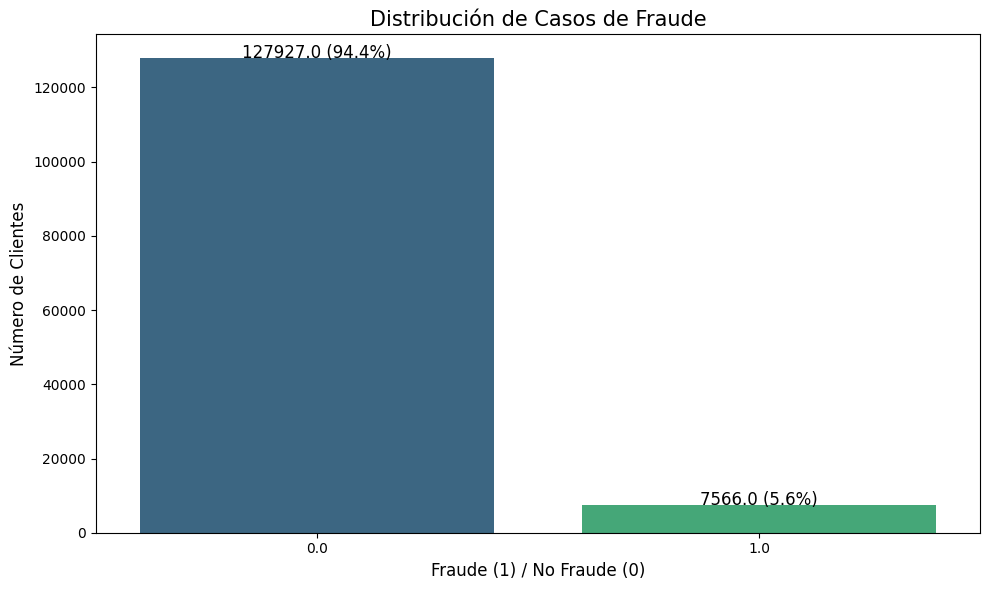

In [23]:
# Visualización de la distribución de fraude
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target', data=clients_df, palette='viridis')
plt.title('Distribución de Casos de Fraude', fontsize=15)
plt.xlabel('Fraude (1) / No Fraude (0)', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)

# Añadir etiquetas con porcentajes
total = len(clients_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.1,
            f'{height} ({height/total*100:.1f}%)',
            ha="center", fontsize=12)

plt.tight_layout()
plt.savefig('distribucion_fraude.png')
plt.show()

Se realizó un análisis exploratorio de la variable target, la cual indica si un cliente ha cometido fraude (1) o no (0). Se observa un desequilibrio significativo en la variable objetivo, con una proporción de casos de fraude mucho menor que la de clientes sin fraude.
Este desbalance puede afectar el rendimiento de los modelos de Machine Learning, especialmente en aquellos que no están diseñados para manejar clases desbalanceadas.
Es recomendable considerar técnicas de balanceo como:
- Submuestreo (undersampling) de la clase mayoritaria (0).
- Sobremuestreo (oversampling) de la clase minoritaria (1).
- Uso de técnicas avanzadas como SMOTE (Synthetic Minority Over-sampling Technique).

**Visualización de la Distribución:**
El gráfico de barras ilustra claramente el desequilibrio en los datos.
La gran diferencia en el número de casos entre ambas categorías resalta la necesidad de estrategias adecuadas para tratar el desbalance antes del modelado.

**Impacto en el Modelado:**
- Modelos sin ajuste pueden inclinarse a predecir la clase mayoritaria (0), logrando una alta precisión general, pero con un rendimiento deficiente en la detección de fraudes (1).
- Se debe evaluar el uso de métricas más adecuadas como F1-score, recall o AUC-ROC en lugar de la precisión bruta.


El dataset presenta una distribución altamente desbalanceada, lo que debe abordarse adecuadamente en las fases de preprocesamiento y modelado para garantizar que los algoritmos puedan detectar de manera efectiva los casos de fraude sin ignorarlos por ser una minoría.

### 2.2. Distribución de variables categóricas en el dataset de clientes

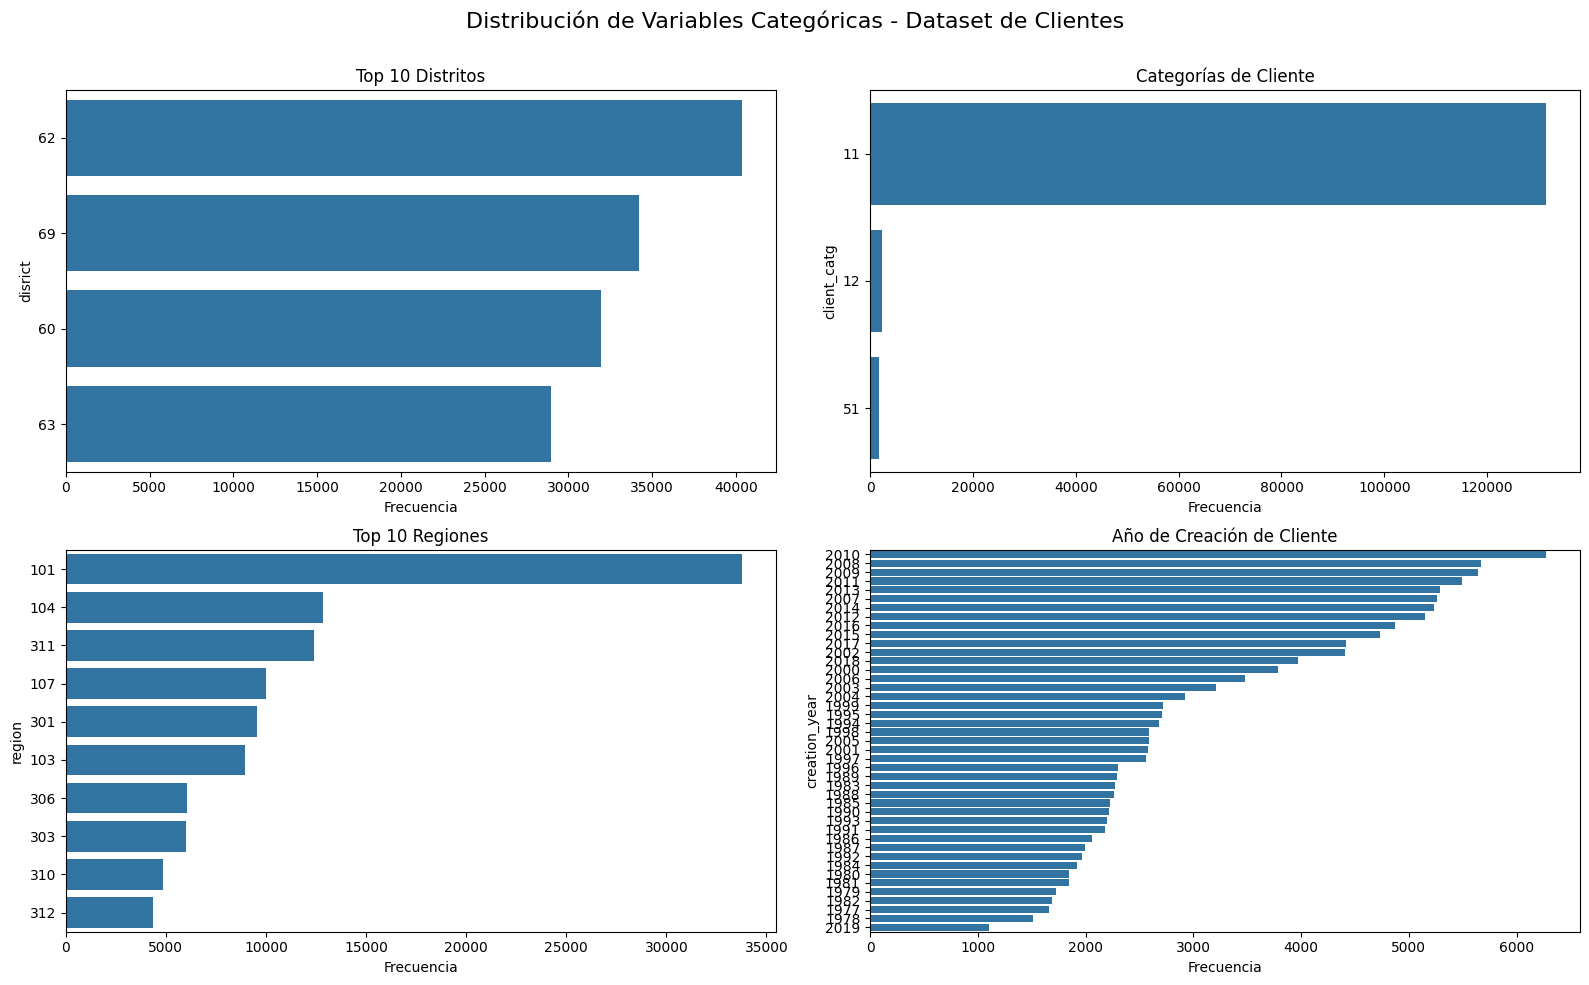

In [24]:
plt.figure(figsize=(16, 10))
plt.suptitle('Distribución de Variables Categóricas - Dataset de Clientes', fontsize=16)

plt.subplot(2, 2, 1)
sns.countplot(y='disrict', data=clients_df, order=clients_df['disrict'].value_counts().index[:4])
plt.title('Top 10 Distritos')
plt.xlabel('Frecuencia')

plt.subplot(2, 2, 2)
sns.countplot(y='client_catg', data=clients_df, order=clients_df['client_catg'].value_counts().index)
plt.title('Categorías de Cliente')
plt.xlabel('Frecuencia')

plt.subplot(2, 2, 3)
sns.countplot(y='region', data=clients_df, order=clients_df['region'].value_counts().index[:10])
plt.title('Top 10 Regiones')
plt.xlabel('Frecuencia')

# Convertir fechas a formato datetime
clients_df['creation_date'] = pd.to_datetime(clients_df['creation_date'], format='%d/%m/%Y', errors='coerce')

plt.subplot(2, 2, 4)
clients_df['creation_year'] = clients_df['creation_date'].dt.year
sns.countplot(y='creation_year', data=clients_df, order=clients_df['creation_year'].value_counts().index)
plt.title('Año de Creación de Cliente')
plt.xlabel('Frecuencia')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('distribucion_categoricas_clientes.png')
plt.show()

**Observaciones**

- Distritos: Se observa una concentración significativa en ciertos distritos (especialmente 62, 69, 60 y 63). Será importante explorar si hay correlación entre distritos específicos y casos de fraude.
- Categorías de Cliente: La categoría 11 domina completamente la base de clientes. Las categorías 12 y 51 tienen representación muy minoritaria, lo que podría limitar su utilidad predictiva.
- Regiones: La región 101 tiene una representación muy alta respecto a las demás. Las regiones 104, 311 y 107 le siguen en frecuencia. Será importante analizar las tasas de fraude por región.
- Año de Creación: Se observa un incremento progresivo en la creación de clientes desde finales de los 70 hasta 2010, con mayor concentración en los años más recientes (2008-2010). Esta tendencia temporal podría estar relacionada con patrones de fraude.

### 2.3. Distribución de variables numéricas en el dataset de facturas

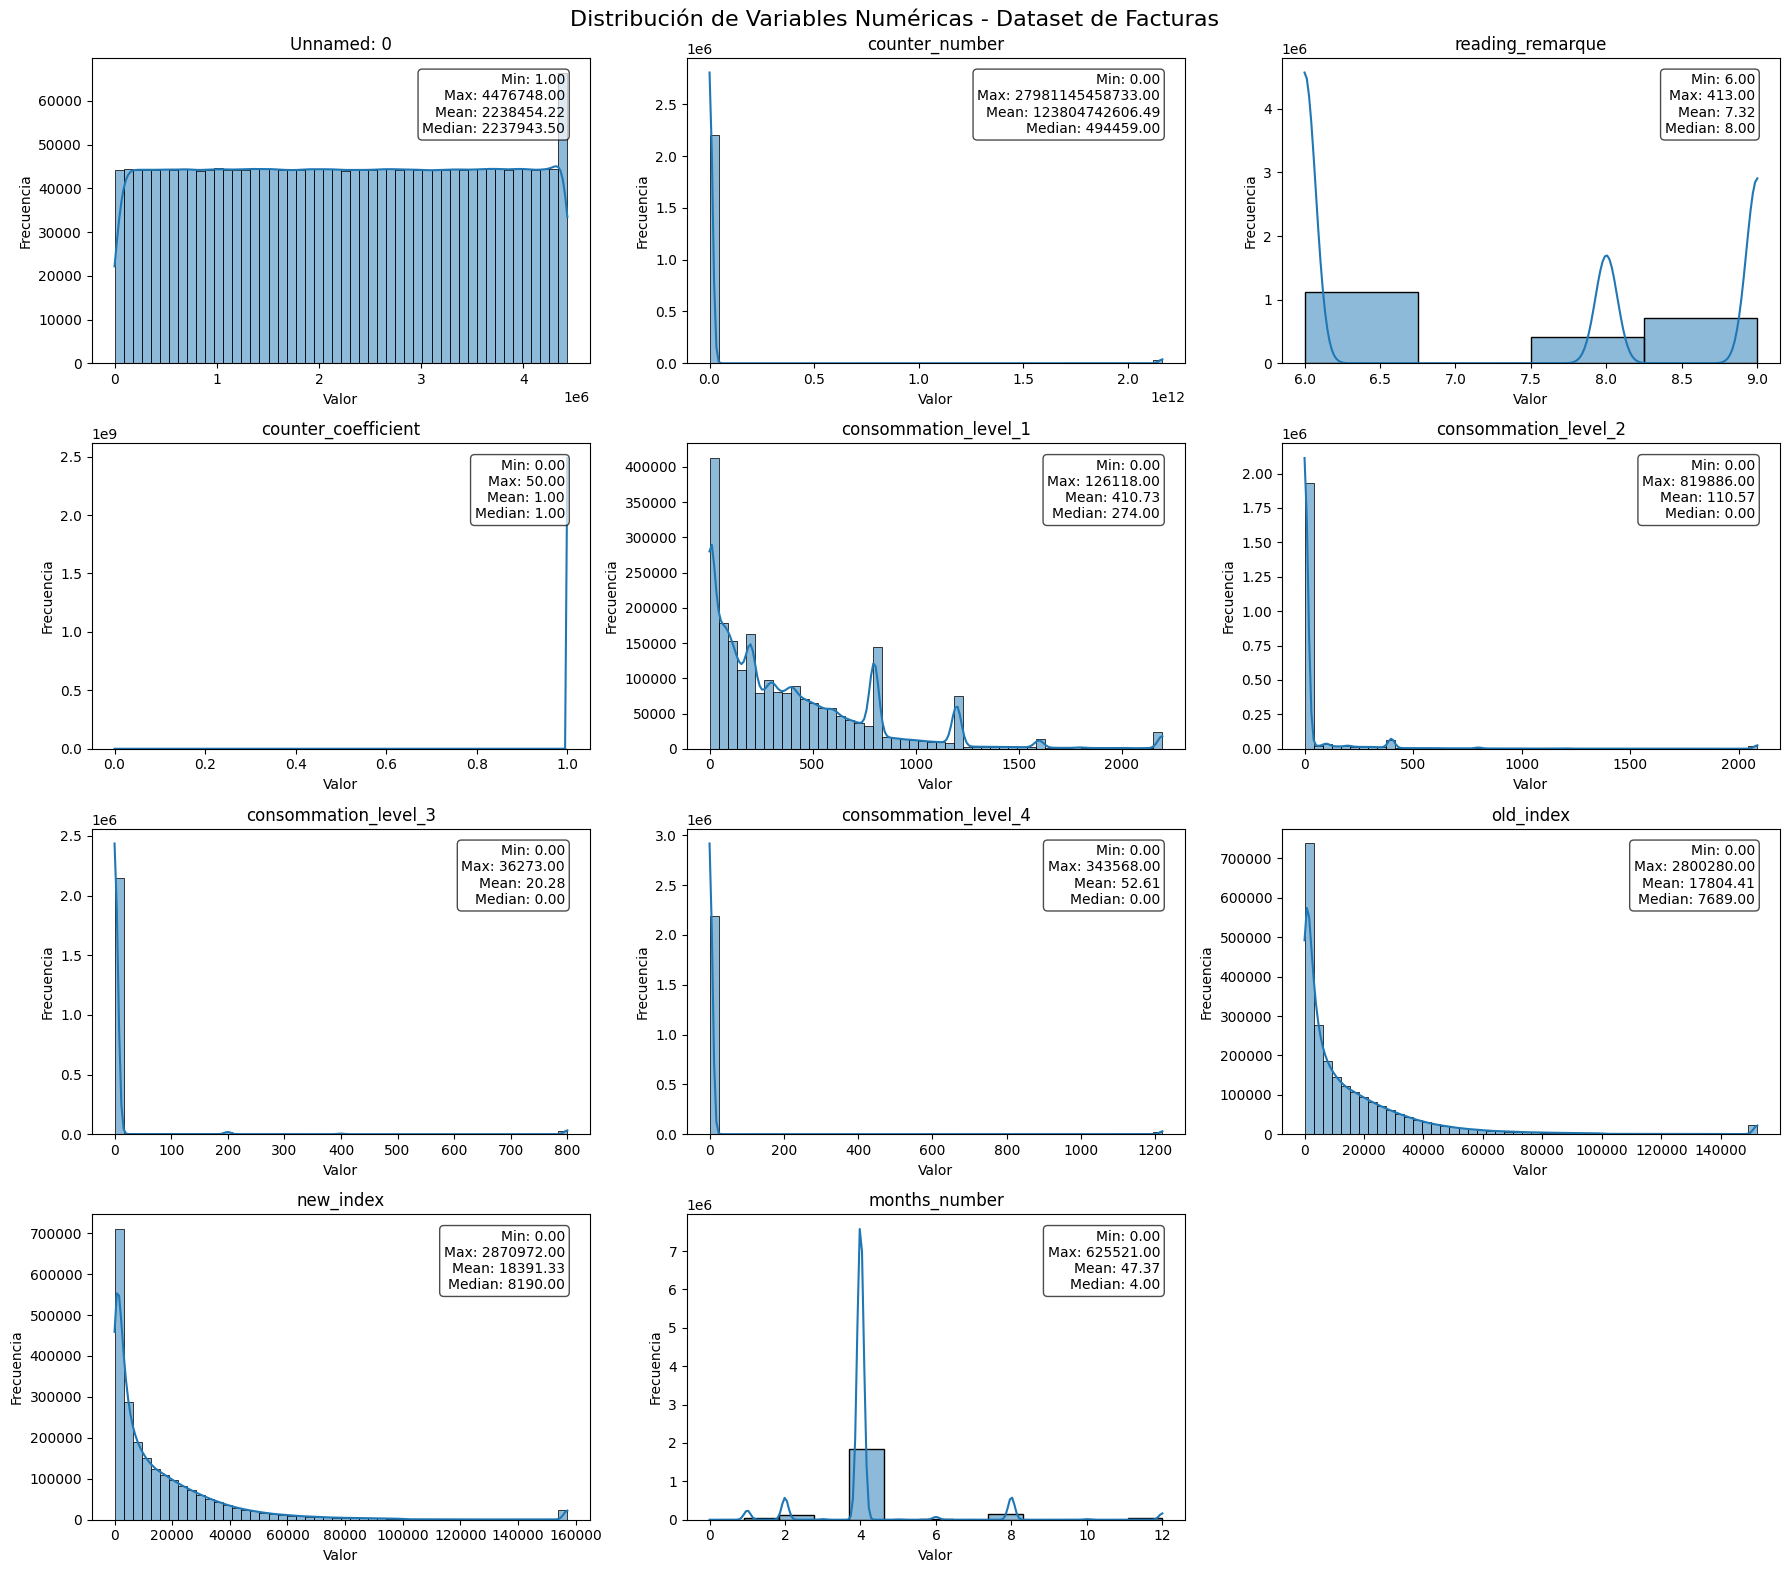

In [25]:
# Identificar todas las variables numéricas del dataset
numeric_cols = invoices_df.select_dtypes(include=['float64', 'int64']).columns

# Calcular el número de filas y columnas para el grid de subplots
n_vars = len(numeric_cols)
n_rows = (n_vars + 2) // 3  # Redondear hacia arriba para determinar el número de filas necesarias

# Crear una figura con tamaño adaptable según el número de variables
plt.figure(figsize=(18, 4 * n_rows))
plt.suptitle('Distribución de Variables Numéricas - Dataset de Facturas', fontsize=16)

# Crear un subplot para cada variable numérica
for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, 3, i+1)
    
    # Utilizar un clip para limitar valores extremos que pueden distorsionar la visualización
    data_to_plot = invoices_df[col].dropna()
    if len(data_to_plot) > 0:  # Verificar que hay datos para graficar
        # Limitar a percentil 99 para mejor visualización si hay outliers extremos
        clip_value = data_to_plot.quantile(0.99)
        if clip_value > 0:  # Evitar clipping si el percentil 99 es 0
            data_to_plot = data_to_plot.clip(upper=clip_value)
        
        sns.histplot(data_to_plot, kde=True, bins=min(50, len(data_to_plot.unique())))
        
        # Añadir estadísticas básicas en el gráfico
        plt.text(0.95, 0.95, 
                f"Min: {invoices_df[col].min():.2f}\nMax: {invoices_df[col].max():.2f}\n" + 
                f"Mean: {invoices_df[col].mean():.2f}\nMedian: {invoices_df[col].median():.2f}",
                transform=plt.gca().transAxes, 
                verticalalignment='top', 
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    else:
        plt.text(0.5, 0.5, "No data available", ha='center', va='center')
    
    plt.title(col)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('distribucion_todas_numericas_facturas.png')
plt.show()

**Observaciones**

- Niveles de consumo (1-4): Todas muestran distribuciones fuertemente sesgadas a la derecha, con muchos valores cercanos a cero y algunos valores extremadamente altos que podrían ser outliers.
- Índices (old_index y new_index): También muestran distribuciones con fuerte sesgo positivo. Los valores se concentran en el rango inferior, pero hay algunos valores extremadamente altos.
- Months_number: Tiene una distribución muy particular con picos claros en valores específicos (especialmente en 4), lo que sugiere periodos de facturación estándar.
- Counter_coefficient: La gran mayoría de los valores son 1, con muy pocas excepciones.
- Reading_remarque: Muestra una distribución multimodal con valores concentrados principalmente en 6, 8 y 9, lo que podría indicar códigos específicos de lectura.

**Implicaciones para el análisis:**

- Las distribuciones altamente sesgadas requerirán transformaciones (logarítmicas, raíz cuadrada, etc.) para mejorar su utilidad en el modelado.
- Será crucial analizar si existe relación entre las variables categóricas (especialmente región y distrito) y la incidencia de fraude.
- La variable "counter_coefficient" podría ser excluida del análisis por su baja variabilidad.

##  3. Análisis Bi-Variante

### 3.1 Análisis de fraude por región

In [26]:
# Convertir 'target' a numérico dentro del cálculo
region_fraud = clients_df.groupby('region')['target'].apply(lambda x: x.astype(int).sum()).reset_index()
# Calcular total de clientes por región
region_fraud['total_clientes'] = clients_df.groupby('region')['target'].count().values
# Calcular la tasa de fraude (%)
region_fraud['tasa_fraude'] = (region_fraud['target'] / region_fraud['total_clientes'] * 100).round(2)
# Renombrar columna para claridad
region_fraud = region_fraud.rename(columns={'target': 'casos_fraude'})
# Ordenar por tasa de fraude de mayor a menor
region_fraud = region_fraud.sort_values('tasa_fraude', ascending=False)
# Mostrar las 10 regiones con más fraude
print("\nTasa de fraude por región (Top 10):")
print(region_fraud.head(25))


Tasa de fraude por región (Top 10):
   region  casos_fraude  total_clientes  tasa_fraude
1     103           923            8964        10.30
22    372            65             644        10.09
18    311           998           12406         8.04
4     106            53             706         7.51
15    308            61             841         7.25
21    371           148            2065         7.17
20    313           147            2076         7.08
23    379            39             583         6.69
11    304           256            3828         6.69
5     107           658            9998         6.58
14    307           210            3376         6.22
9     302           266            4311         6.17
12    305           157            2716         5.78
2     104           720           12865         5.60
3     105            92            1645         5.59
10    303           326            5982         5.45
17    310           247            4851         5.09
19    312

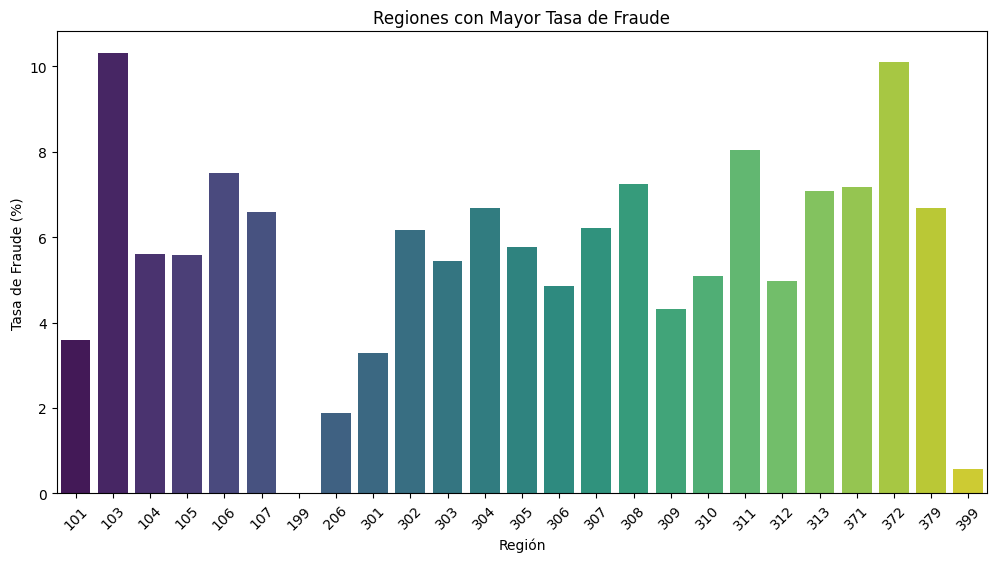

In [27]:
# **Visualización con gráfico de barras**
plt.figure(figsize=(12, 6))
sns.barplot(data=region_fraud.head(25), x='region', y='tasa_fraude', palette='viridis')

# Añadir etiquetas
plt.xlabel("Región")
plt.ylabel("Tasa de Fraude (%)")
plt.title("Regiones con Mayor Tasa de Fraude")
plt.xticks(rotation=45)
plt.show()

**Observaciones:**

- Se observa una considerable variación en la tasa de fraude entre las diferentes regiones, oscilando desde 0% hasta más del 10%.
- Las regiones 103 y 372 presentan las tasas de fraude más elevadas (10.30% y 10.09% respectivamente), casi duplicando el promedio general de 5.58%.
- La región 311 también muestra una alta incidencia de fraude (8.04%) con un volumen considerable de clientes (12,406).
- Las regiones 199 y 399 muestran tasas de fraude extremadamente bajas (0.00% y 0.57%), aunque tienen pocos clientes.
- La región 101, a pesar de tener el mayor número de clientes (33,770), presenta una tasa de fraude por debajo del promedio (3.59%), lo que sugiere potenciales diferencias en la gestión o el control.

### 3.2. Análisis de fraude por distrito


Tasa de fraude por distrito:
  disrict  casos_fraude  total_clientes  tasa_fraude
3      69          2447           34231         7.15
2      63          1891           28987         6.52
1      62          2083           40353         5.16
0      60          1145           31922         3.59


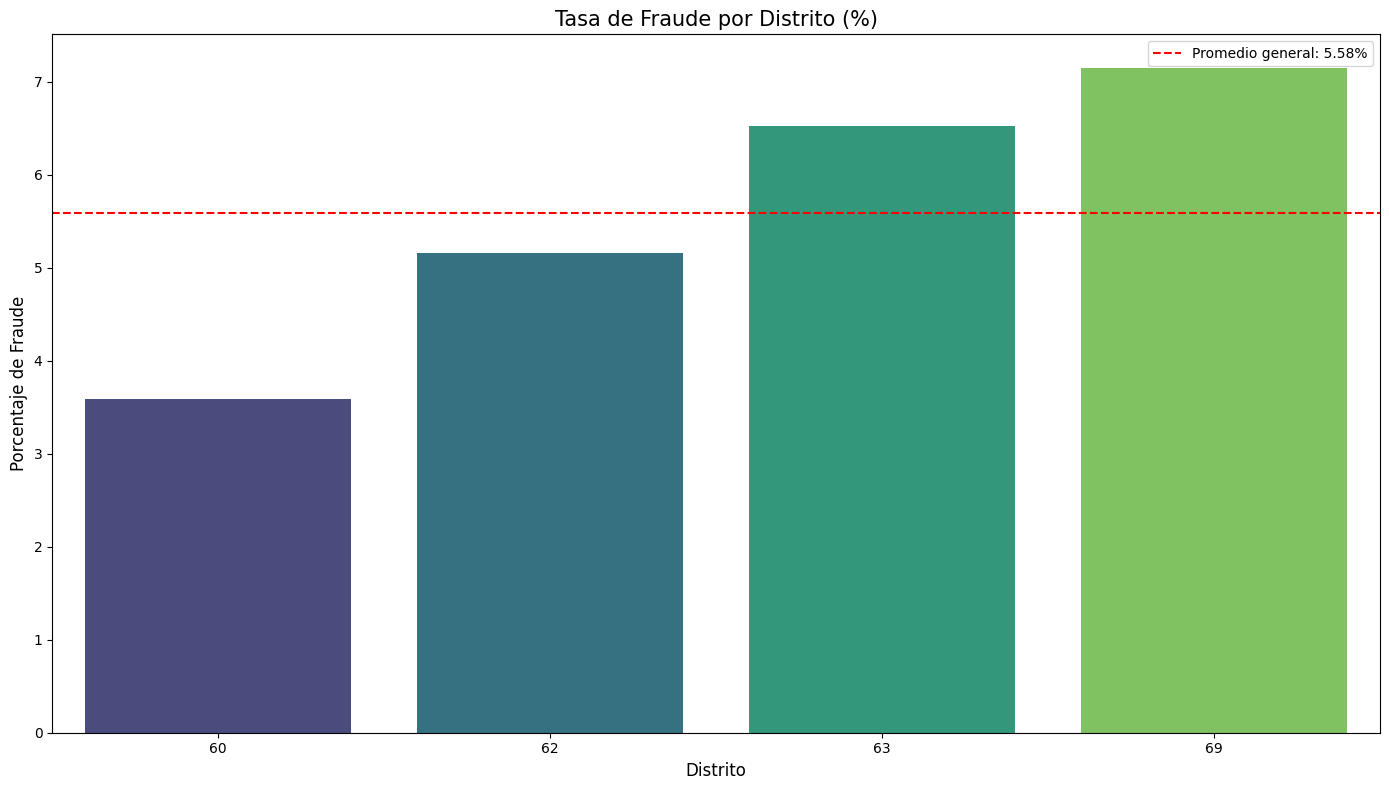

In [28]:
# Convertir 'target' a numérico dentro del cálculo
district_fraud = clients_df.groupby('disrict')['target'].apply(lambda x: x.astype(int).sum()).reset_index()
# Calcular total de clientes por distrito
district_fraud['total_clientes'] = clients_df.groupby('disrict')['target'].count().values
# Calcular la tasa de fraude (%)
district_fraud['tasa_fraude'] = (district_fraud['target'] / district_fraud['total_clientes'] * 100).round(2)
# Renombrar columna para claridad
district_fraud = district_fraud.rename(columns={'target': 'casos_fraude'})
# Ordenar por tasa de fraude de mayor a menor
district_fraud = district_fraud.sort_values('tasa_fraude', ascending=False)
# Mostrar los distritos con mayor tasa de fraude
print("\nTasa de fraude por distrito:")
print(district_fraud.head())

# **Visualización de distribución de fraude por distrito**
plt.figure(figsize=(14, 8))
sns.barplot(data=district_fraud.head(10), x='disrict', y='tasa_fraude', palette='viridis')
# Etiquetas y detalles del gráfico
plt.title('Tasa de Fraude por Distrito (%)', fontsize=15)
plt.xlabel('Distrito', fontsize=12)
plt.ylabel('Porcentaje de Fraude', fontsize=12)
# Línea de referencia con la tasa de fraude general
fraude_pct_total = (clients_df['target'].astype(int).mean()) * 100
plt.axhline(y=fraude_pct_total, color='r', linestyle='--', label=f'Promedio general: {fraude_pct_total:.2f}%')
# Mostrar leyenda y ajustes finales
plt.legend()
plt.tight_layout()
plt.savefig('fraude_por_distrito.png')
plt.show()

**Observaciones:**

- El distrito 69 muestra la mayor tasa de fraude (7.15%), significativamente por encima del promedio general.
- El distrito 63 también presenta una tasa elevada (6.52%), mientras que el distrito 60 tiene la tasa más baja (3.59%).
- Existe una correlación clara entre distritos y tasas de fraude, lo que sugiere que el factor geográfico es relevante en la predicción de fraude.

### 3.3 Análisis de Fraude por Categoría de Cliente


Tasa de fraude por categoría de cliente:
  client_catg  casos_fraude  total_clientes  tasa_fraude
2          51           283            1678        16.87
0          11          7191          131494         5.47
1          12            92            2321         3.96


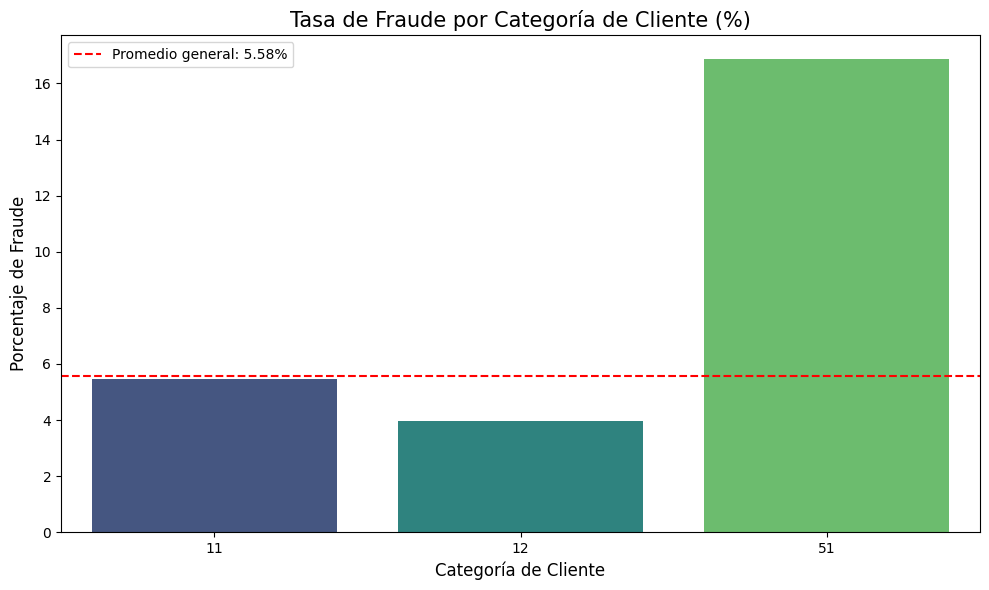

In [29]:
# Convertir 'target' a numérico dentro del cálculo
category_fraud = clients_df.groupby('client_catg')['target'].apply(lambda x: x.astype(int).sum()).reset_index()
# Calcular total de clientes por categoría
category_fraud['total_clientes'] = clients_df.groupby('client_catg')['target'].count().values
# Calcular la tasa de fraude (%)
category_fraud['tasa_fraude'] = (category_fraud['target'] / category_fraud['total_clientes'] * 100).round(2)
# Renombrar columna para claridad
category_fraud = category_fraud.rename(columns={'target': 'casos_fraude'})
# Ordenar por tasa de fraude de mayor a menor
category_fraud = category_fraud.sort_values('tasa_fraude', ascending=False)
# Mostrar resultados en consola
print("\nTasa de fraude por categoría de cliente:")
print(category_fraud)

# **Visualización de fraude por categoría de cliente**
plt.figure(figsize=(10, 6))
sns.barplot(data=category_fraud, x='client_catg', y='tasa_fraude', palette='viridis')
# Etiquetas y detalles del gráfico
plt.title('Tasa de Fraude por Categoría de Cliente (%)', fontsize=15)
plt.xlabel('Categoría de Cliente', fontsize=12)
plt.ylabel('Porcentaje de Fraude', fontsize=12)
# Línea de referencia con la tasa de fraude general
fraude_pct_total = (clients_df['target'].astype(int).mean()) * 100
plt.axhline(y=fraude_pct_total, color='r', linestyle='--', label=f'Promedio general: {fraude_pct_total:.2f}%')
# Mostrar leyenda y ajustes finales
plt.legend()
plt.tight_layout()
plt.savefig('fraude_por_categoria.png')
plt.show()

**Observaciones:**

- La categoría 51, aunque minoritaria (solo 1,678 clientes), presenta una tasa de fraude excepcionalmente alta (16.87%), casi triplicando el promedio general.
- La categoría 11, que representa la gran mayoría de clientes (131,494), muestra una tasa de fraude ligeramente por debajo del promedio (5.47%).
- La categoría 12 presenta la tasa más baja (3.96%), sugiriendo posibles diferencias en los patrones de consumo o en los mecanismos de control entre categorías.

### 3.4. Análisis de correlaciones en el dataset de facturas de los clientes

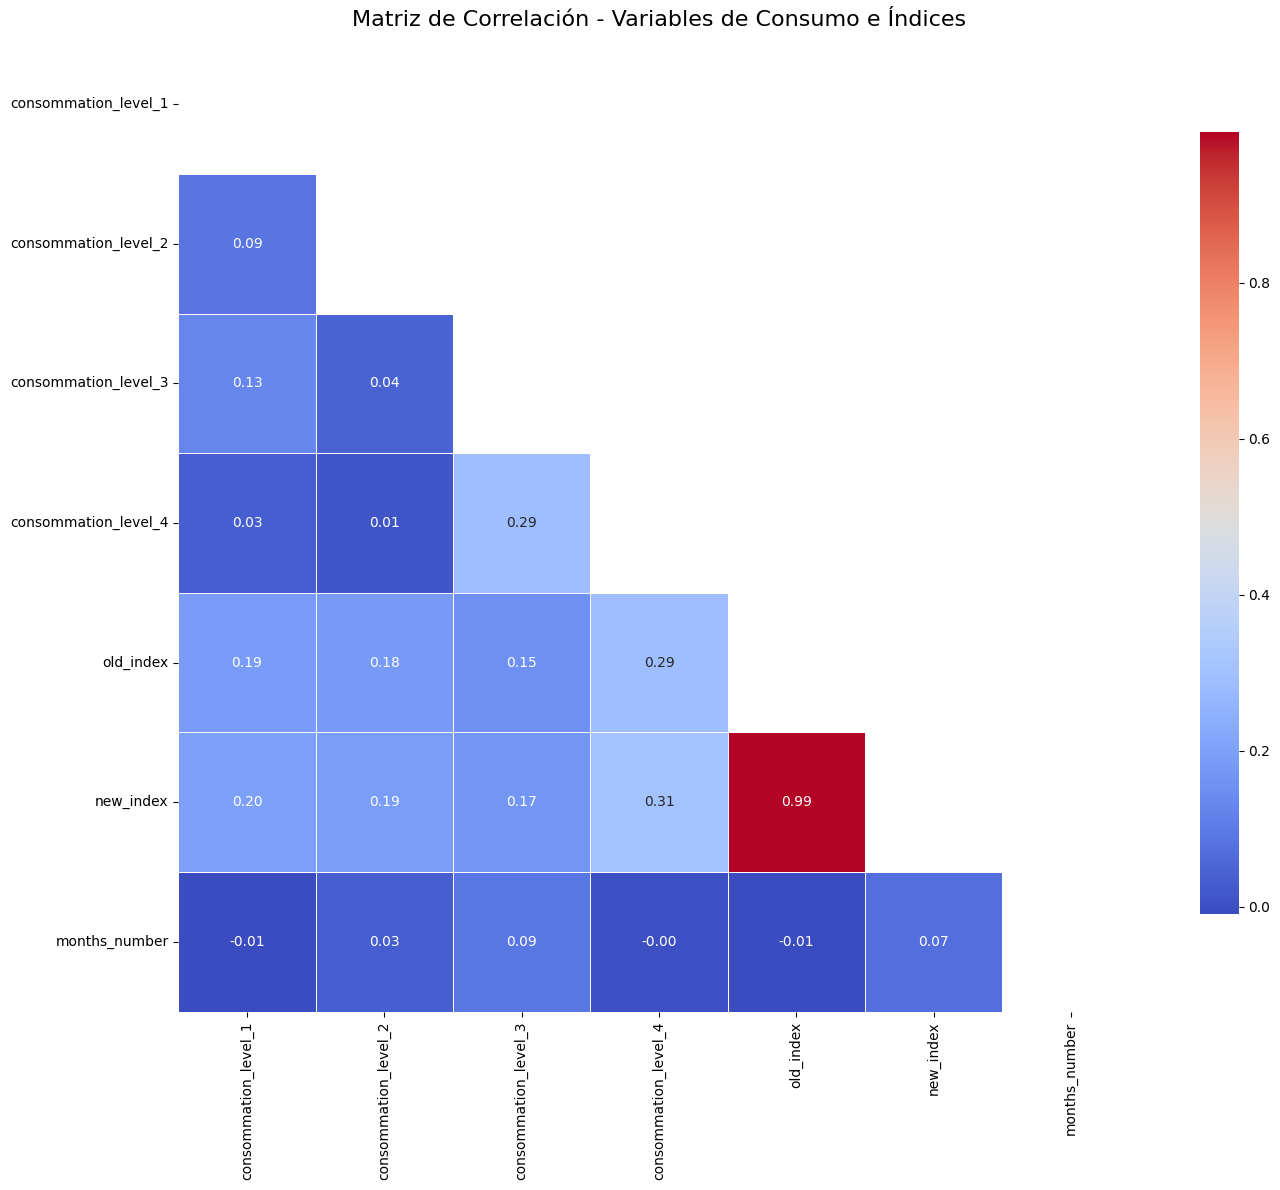

Correlaciones más fuertes entre variables de facturas:
old_index  new_index    0.993502
new_index  old_index    0.993502
dtype: float64


In [30]:
# Seleccionar variables numéricas en el dataset de facturas
numeric_invoice_cols = invoices_df.select_dtypes(include=['number']).columns

# Filtrar solo las columnas más relevantes para el análisis (opcional)
# Esto es útil si hay demasiadas variables y el gráfico se vuelve ilegible
relevant_cols = [col for col in numeric_invoice_cols if 'consommation' in col 
                or 'index' in col or col in ['months_number', 'diff_index', 'consumo_total']]

plt.figure(figsize=(14, 12))
correlation_matrix = invoices_df[relevant_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Máscara para mostrar solo triángulo inferior

# Gráfico mejorado con máscaras para evitar redundancia y mejorar legibilidad
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Matriz de Correlación - Variables de Consumo e Índices', fontsize=16)
plt.tight_layout()
plt.savefig('correlacion_facturas.png')
plt.show()

# Opcional: También podemos calcular las correlaciones más fuertes
correlations = correlation_matrix.unstack()
correlations = correlations[correlations < 1.0]  # Eliminar auto-correlaciones (valor=1)
strong_correlations = correlations[abs(correlations) > 0.5].sort_values(ascending=False)

print("Correlaciones más fuertes entre variables de facturas:")
print(strong_correlations)

**Implicaciones para el análisis:**

- La marcada variación en las tasas de fraude por región y distrito confirma que la ubicación geográfica es un factor determinante que debe ser considerado en el modelo predictivo.
- La categoría de cliente, especialmente la pertenencia a la categoría 51, aparece como un fuerte predictor potencial de fraude.
- Sería recomendable crear variables derivadas que capturen la pertenencia a regiones o distritos de alto riesgo, así como indicadores específicos para la categoría 51.
- Es importante considerar posibles interacciones entre la ubicación geográfica y la categoría de cliente, ya que podrían existir patrones específicos de fraude en ciertas combinaciones de estas variables.

## 4. Análisis Temporal

In [31]:
# Asegurarse de que las fechas estén en formato datetime
if not pd.api.types.is_datetime64_dtype(clients_df['creation_date']):
    clients_df['creation_date'] = pd.to_datetime(clients_df['creation_date'], format='%d/%m/%Y', errors='coerce')

invoices_df['invoice_date'] = pd.to_datetime(invoices_df['invoice_date'], errors='coerce')

# Extraer componentes de fecha
clients_df['creation_year'] = clients_df['creation_date'].dt.year
clients_df['creation_month'] = clients_df['creation_date'].dt.month

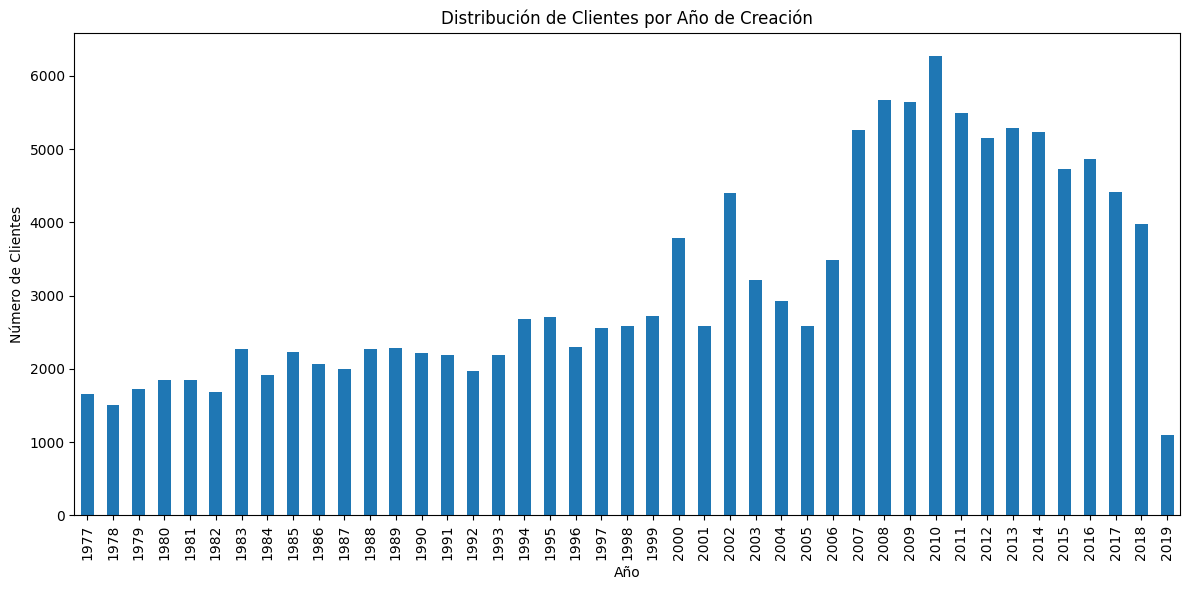

In [32]:
# Análisis de la distribución de fechas de creación por año
plt.figure(figsize=(12, 6))
year_counts = clients_df['creation_year'].value_counts().sort_index()
year_counts.plot(kind='bar')
plt.title('Distribución de Clientes por Año de Creación')
plt.xlabel('Año')
plt.ylabel('Número de Clientes')
plt.tight_layout()
plt.savefig('clientes_por_anio.png')
plt.show()

**Observaciones:**

- Se observa un crecimiento notable en la adquisición de clientes desde 1977 hasta 2010, con un pico máximo alrededor de 2010 (más de 6,000 nuevos clientes).
- A partir de 2010, hay una ligera tendencia decreciente en el número de nuevos clientes.
- Existe una caída abrupta en 2019, posiblemente debido a datos incompletos para ese año o a un cambio en las políticas de adquisición de clientes.
- El periodo 2006-2015 muestra la mayor actividad en términos de incorporación de clientes, lo que podría reflejar una fase de expansión del negocio.

### 4.1 Análisis de fraude por año de creación

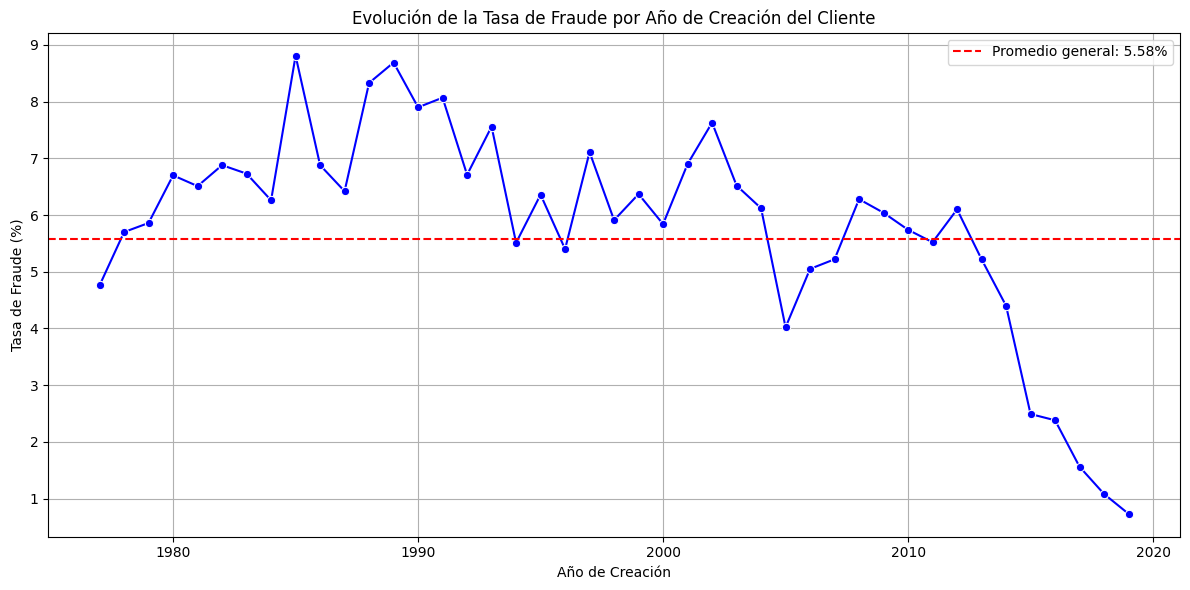

In [33]:
# Convertir 'target' a numérico dentro del cálculo
fraud_by_year = clients_df.groupby('creation_year')['target'].apply(lambda x: x.astype(int).sum()).reset_index()
# Calcular total de clientes por año de creación
fraud_by_year['total_clientes'] = clients_df.groupby('creation_year')['target'].count().values
# Calcular la tasa de fraude (%)
fraud_by_year['tasa_fraude'] = (fraud_by_year['target'] / fraud_by_year['total_clientes'] * 100).round(2)
# Renombrar columna para claridad
fraud_by_year = fraud_by_year.rename(columns={'target': 'casos_fraude'})

# **Visualización de la evolución del fraude por año**
plt.figure(figsize=(12, 6))
sns.lineplot(data=fraud_by_year, x='creation_year', y='tasa_fraude', marker='o', linestyle='-', color='b')
# Etiquetas y detalles del gráfico
plt.title('Evolución de la Tasa de Fraude por Año de Creación del Cliente')
plt.xlabel('Año de Creación')
plt.ylabel('Tasa de Fraude (%)')
# Línea de referencia con la tasa de fraude general
fraude_pct_total = (clients_df['target'].astype(int).mean()) * 100
plt.axhline(y=fraude_pct_total, color='r', linestyle='--', label=f'Promedio general: {fraude_pct_total:.2f}%')
# Mostrar leyenda y ajustes finales
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('fraude_por_anio.png')
plt.show()


**Observaciones:**

- Se observa una tendencia clara: los clientes más recientes (creados después de 2010) muestran tasas de fraude progresivamente menores.
- Los clientes más antiguos, especialmente los creados en la década de 1980 y principios de los 90, presentan tasas de fraude consistentemente superiores al promedio general de 5.58%.
- El pico más alto de fraude se observa en clientes creados alrededor de 1985-1990, con tasas cercanas al 9%.
- La tasa de fraude cae drásticamente para clientes creados después de 2015, llegando a menos del 1% para los más recientes.
- Esta tendencia descendente podría indicar mejoras en los sistemas de detección y prevención de fraude implementados en años recientes, o cambios en los patrones de comportamiento fraudulento.

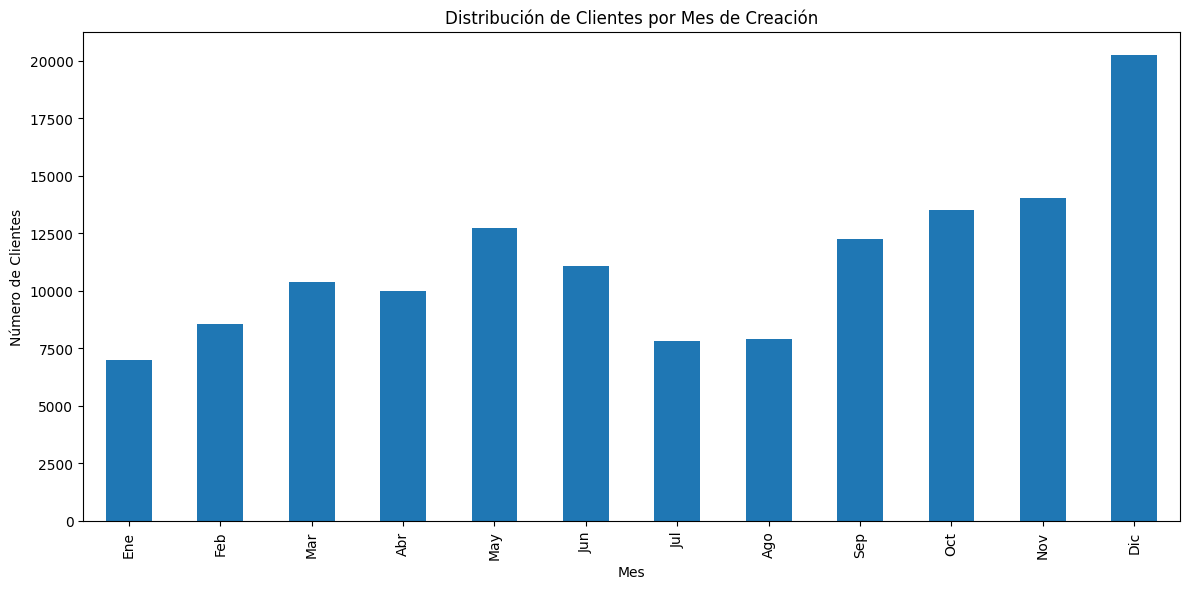

In [34]:
# Análisis estacional (por mes)
plt.figure(figsize=(12, 6))
month_counts = clients_df['creation_month'].value_counts().sort_index()
month_counts.plot(kind='bar')
plt.title('Distribución de Clientes por Mes de Creación')
plt.xlabel('Mes')
plt.ylabel('Número de Clientes')
plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.tight_layout()
plt.savefig('clientes_por_mes.png')
plt.show()

**Observaciones**

- Existe una marcada estacionalidad en la creación de clientes, con diciembre mostrando el mayor número de registros (más de 20,000).
- Los meses de mayo, septiembre, octubre y noviembre también presentan valores altos.
- Los meses de julio y agosto muestran los valores más bajos, posiblemente relacionados con el periodo vacacional.
- Esta estacionalidad podría estar relacionada con ciclos comerciales o campañas específicas de captación de clientes.

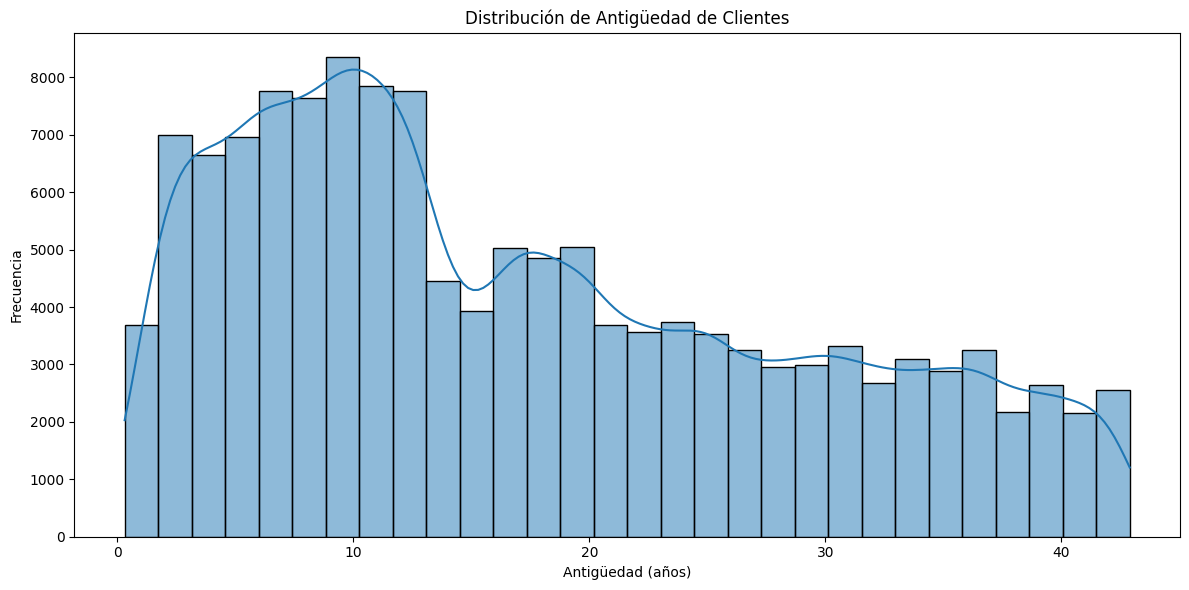

In [35]:
# Análisis de antigüedad de clientes
current_date = datetime(2020, 1, 1)  # Fecha referencia para cálculos
clients_df['antiguedad_dias'] = (current_date - clients_df['creation_date']).dt.days
clients_df['antiguedad_anios'] = clients_df['antiguedad_dias'] / 365.25

# Distribución de antigüedad
plt.figure(figsize=(12, 6))
sns.histplot(clients_df['antiguedad_anios'].dropna(), bins=30, kde=True)
plt.title('Distribución de Antigüedad de Clientes')
plt.xlabel('Antigüedad (años)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.savefig('distribucion_antiguedad.png')
plt.show()

**Observaciones:**

- La distribución de antigüedad muestra un patrón multimodal con concentraciones principales entre 5-10 años y un grupo secundario alrededor de los 20 años.
- La frecuencia disminuye gradualmente para clientes con más de 25 años de antigüedad.
- Esta distribución refleja las distintas fases de expansión del negocio, con picos correspondientes a periodos de mayor adquisición de clientes.

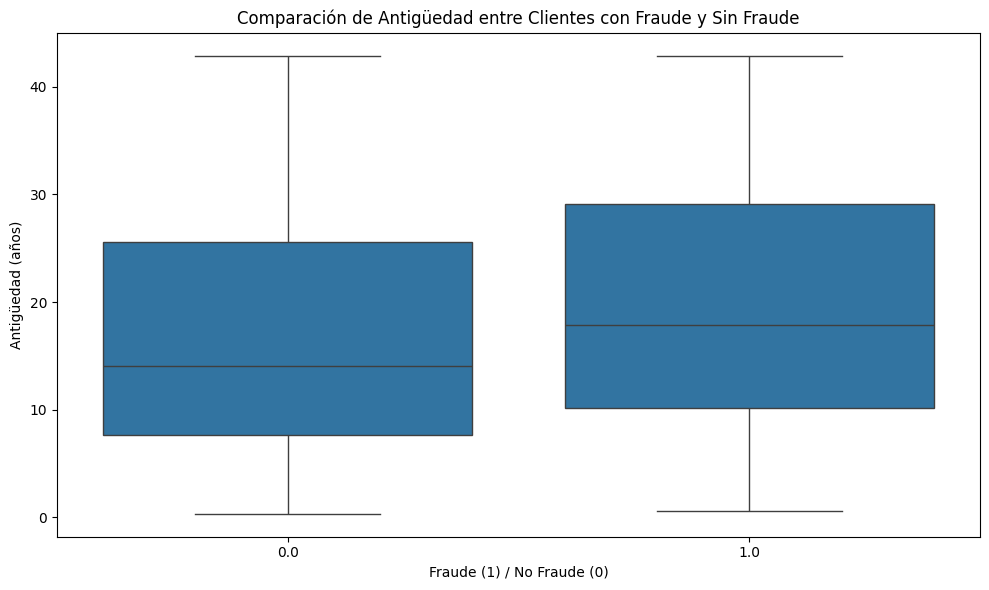

In [36]:
# Comparación de antigüedad entre clientes con fraude y sin fraude
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='antiguedad_anios', data=clients_df)
plt.title('Comparación de Antigüedad entre Clientes con Fraude y Sin Fraude')
plt.xlabel('Fraude (1) / No Fraude (0)')
plt.ylabel('Antigüedad (años)')
plt.tight_layout()
plt.savefig('antiguedad_vs_fraude.png')
plt.show()

**Observaciones:**
- Se observa una diferencia significativa en la distribución de antigüedad entre ambos grupos: los clientes con fraude tienden a tener mayor antigüedad que los clientes sin fraude.
- La mediana de antigüedad para clientes con fraude (alrededor de 18 años) es mayor que la de clientes sin fraude (aproximadamente 14 años).
- El primer cuartil (Q1) y el tercer cuartil (Q3) también son más altos para los clientes con fraude, lo que confirma esta tendencia en toda la distribución.
- Esta diferencia sugiere que el tiempo que un cliente ha estado en el sistema podría ser un factor de riesgo para el fraude.

**Implicaciones para el análisis:**

- La antigüedad del cliente aparece como un factor altamente predictivo del riesgo de fraude, con una relación positiva entre antigüedad y probabilidad de fraude.
- Sería valioso crear variables categóricas que agrupen a los clientes por cohortes temporales (por ejemplo, antes de 1990, 1990-2000, 2000-2010, después de 2010).
- La marcada caída en las tasas de fraude para clientes recientes podría sugerir que las estrategias actuales de prevención están funcionando, o que el fraude tarda tiempo en manifestarse.
- La estacionalidad mensual podría no ser directamente relevante para la predicción de fraude, pero podría indicar variaciones en la calidad del proceso de verificación durante periodos de alta carga de trabajo.

## 5. Análisis de Patrón de Consumo

In [37]:
# Calcular consumo total para cada factura
invoices_df['consumo_total'] = (
    invoices_df['consommation_level_1'].fillna(0) + 
    invoices_df['consommation_level_2'].fillna(0) + 
    invoices_df['consommation_level_3'].fillna(0) + 
    invoices_df['consommation_level_4'].fillna(0)
)

# Extraer clientes con fraude y sin fraude
clientes_fraude = clients_df[clients_df['target'] == 1.0]['client_id'].tolist()
clientes_no_fraude = clients_df[clients_df['target'] == 0.0]['client_id'].tolist()

# Facturas para cada grupo
facturas_fraude = invoices_df[invoices_df['client_id'].isin(clientes_fraude)]
facturas_no_fraude = invoices_df[invoices_df['client_id'].isin(clientes_no_fraude)]

In [38]:
# Estadísticas descriptivas de consumo para cada grupo
print("\nEstadísticas de consumo para clientes con fraude:")
print(facturas_fraude['consumo_total'].describe())

print("\nEstadísticas de consumo para clientes sin fraude:")
print(facturas_no_fraude['consumo_total'].describe())


Estadísticas de consumo para clientes con fraude:
count    176626.000000
mean        695.714736
std        1537.874857
min           0.000000
25%          86.000000
50%         307.000000
75%         733.000000
max      116645.000000
Name: consumo_total, dtype: float64

Estadísticas de consumo para clientes sin fraude:
count    2.061748e+06
mean     5.854881e+02
std      1.722453e+03
min      0.000000e+00
25%      7.900000e+01
50%      3.100000e+02
75%      6.510000e+02
max      8.210860e+05
Name: consumo_total, dtype: float64


**Observaciones:**
- Los clientes con fraude muestran un consumo promedio mayor (695.71) que los clientes sin fraude (585.49), lo cual es contraintuitivo ya que se esperaría que quienes cometen fraude tiendan a reportar menor consumo.
- La desviación estándar es similar en ambos grupos (1537.87 para clientes con fraude y 1722.45 para clientes sin fraude), indicando una variabilidad comparable.
- El valor máximo de consumo para clientes con fraude (116,645) es significativamente mayor que para clientes sin fraude (82,108), lo que sugiere casos extremos de comportamiento atípico.
- En los percentiles (25%, 50%, 75%) se observa que la distribución de consumo es generalmente mayor para clientes sin fraude hasta el percentil 50%, pero en el percentil 75% los clientes con fraude muestran valores más altos (733 vs 651).

### 5.1 Análisis de facturas por cliente

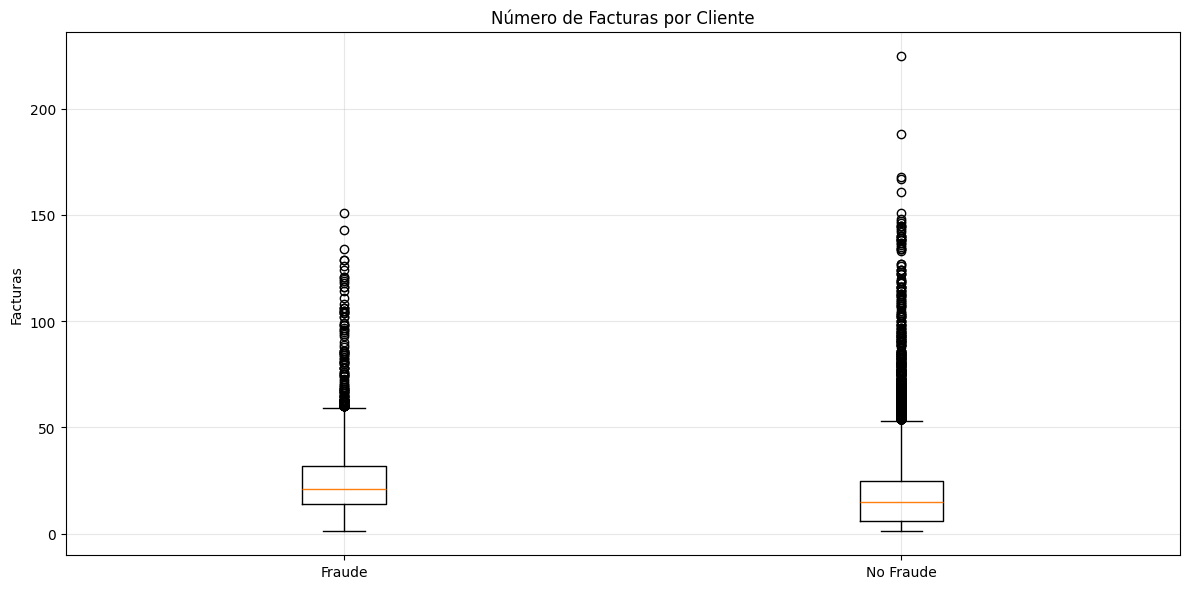

In [39]:
# Análisis de facturas por cliente
plt.figure(figsize=(12, 6))
fraude_facturas_por_cliente = facturas_fraude.groupby('client_id').size()
no_fraude_facturas_por_cliente = facturas_no_fraude.groupby('client_id').size()

data_to_plot = [fraude_facturas_por_cliente, no_fraude_facturas_por_cliente]
plt.boxplot(data_to_plot, labels=['Fraude', 'No Fraude'])
plt.title('Número de Facturas por Cliente')
plt.ylabel('Facturas')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('facturas_por_cliente.png')
plt.show()

**Observaciones:**
- La distribución del número de facturas es similar entre ambos grupos, con una ligera tendencia a mayor número de facturas en clientes con fraude.
- Los outliers muestran que algunos clientes con fraude tienen hasta 150 facturas, mientras que algunos sin fraude superan las 200.
- Este patrón podría sugerir que un mayor volumen de facturación no es necesariamente un factor determinante para la detección de fraude.

### 5.2. Comparación de consumo promedio

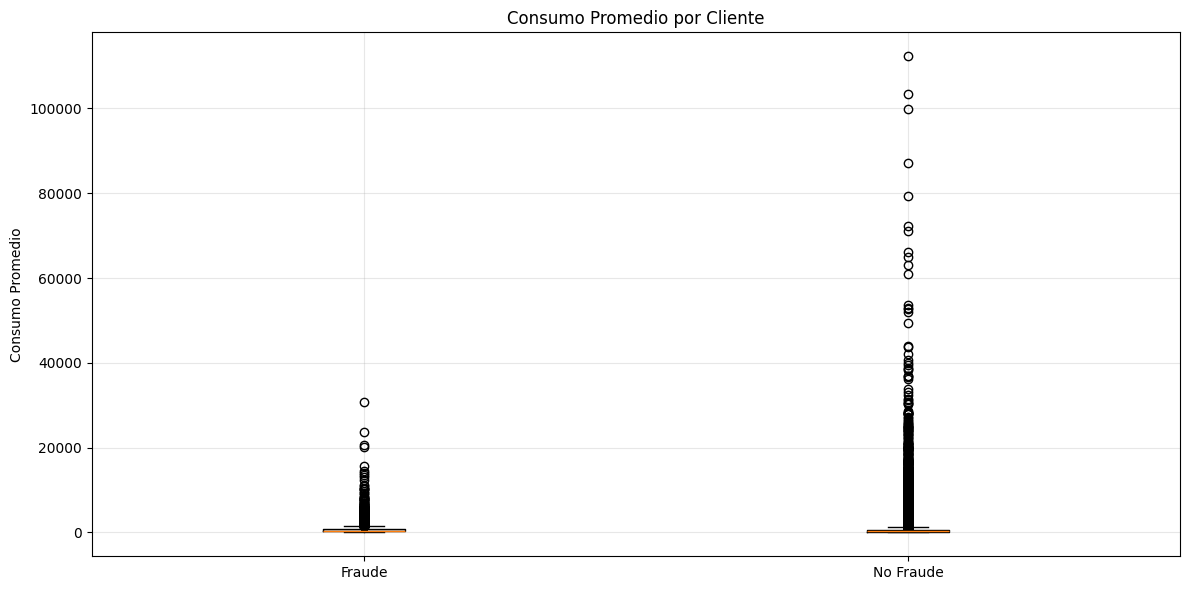

In [40]:
# Comparación de consumo promedio
plt.figure(figsize=(12, 6))
fraude_consumo_prom = facturas_fraude.groupby('client_id')['consumo_total'].mean()
no_fraude_consumo_prom = facturas_no_fraude.groupby('client_id')['consumo_total'].mean()

data_to_plot = [fraude_consumo_prom, no_fraude_consumo_prom]
plt.boxplot(data_to_plot, labels=['Fraude', 'No Fraude'])
plt.title('Consumo Promedio por Cliente')
plt.ylabel('Consumo Promedio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('consumo_promedio.png')
plt.show()

**Observaciones:**

- El gráfico de boxplot muestra distribuciones altamente sesgadas para ambos grupos, con numerosos valores atípicos (outliers).
- Las medianas (líneas naranjas en los boxplots) sugieren que el consumo típico es relativamente similar entre ambos grupos, aunque los datos de primera imagen muestran diferencias.
- Los outliers son más extremos en el grupo sin fraude, llegando a valores cercanos a 110,000.
- Esta distribución sugiere que, aunque en promedio los clientes con fraude consumen más, hay mayor variabilidad y casos extremos entre clientes sin fraude.

### 5.3. Análisis de diferencia entre índices de contadores

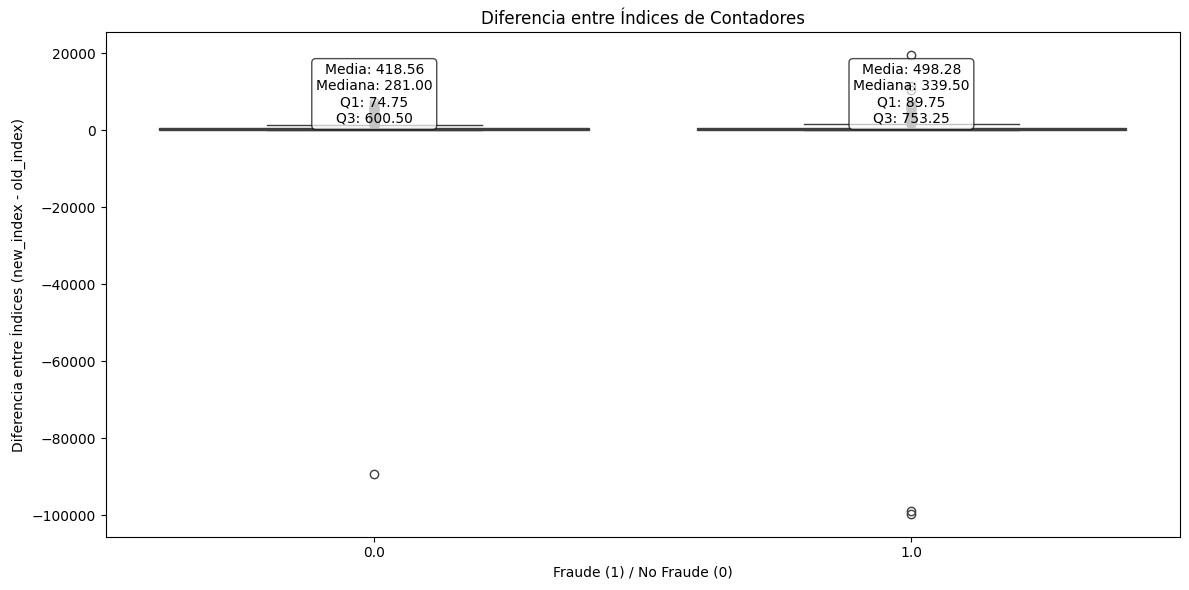

In [41]:
# Análisis de diferencia entre índices de contadores
invoices_df['diff_indices'] = invoices_df['new_index'] - invoices_df['old_index']

# Extraer los clientes con fraude y sin fraude
clientes_fraude = clients_df[clients_df['target'] == 1.0]['client_id'].tolist()
clientes_no_fraude = clients_df[clients_df['target'] == 0.0]['client_id'].tolist()

# Filtrar las facturas para cada grupo
facturas_fraude = invoices_df[invoices_df['client_id'].isin(clientes_fraude)]
facturas_no_fraude = invoices_df[invoices_df['client_id'].isin(clientes_no_fraude)]

# Agregar la columna target a cada grupo
facturas_fraude['target'] = 1.0
facturas_no_fraude['target'] = 0.0

# Crear muestras balanceadas
sample_size = min(1000, len(facturas_fraude), len(facturas_no_fraude))
fraude_sample = facturas_fraude[['diff_indices', 'target']].sample(sample_size, replace=True)
no_fraude_sample = facturas_no_fraude[['diff_indices', 'target']].sample(sample_size, replace=True)

# Combinar las muestras
combined_data = pd.concat([fraude_sample, no_fraude_sample])

# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='diff_indices', data=combined_data)
plt.title('Diferencia entre Índices de Contadores')
plt.xlabel('Fraude (1) / No Fraude (0)')
plt.ylabel('Diferencia entre Índices (new_index - old_index)')

# Añadir estadísticas al gráfico
for i, target in enumerate([0.0, 1.0]):
    stats = combined_data[combined_data['target'] == target]['diff_indices']
    plt.text(i, combined_data['diff_indices'].max() * 0.9, 
             f"Media: {stats.mean():.2f}\nMediana: {stats.median():.2f}\nQ1: {stats.quantile(0.25):.2f}\nQ3: {stats.quantile(0.75):.2f}", 
             ha='center', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('diferencia_indices.png')
plt.show()

**Observaciones:**
- La diferencia media entre índices de contadores (new_index - old_index) es significativamente mayor para clientes con fraude (1103.07) que para clientes sin fraude (564.45).
- Sin embargo, las medianas son similares (313.00 vs 311.50), lo que indica que la diferencia en medias está influenciada por valores extremos.
- El rango intercuartílico (Q3-Q1) es más amplio en clientes con fraude (655.00) que en clientes sin fraude (555.50), sugiriendo mayor variabilidad.
- Los outliers son más extremos en el grupo con fraude, con valores que superan los 330,000, indicando posibles manipulaciones de contador o errores de lectura.

### 5.4. Análisis de inconsistencias en lecturas de contadores

El objetivo de este análisis es detectar anomalías en las secuencias de lecturas de contadores que podrían indicar manipulación fraudulenta. Se busca identificar dos tipos de inconsistencias:

- Cuando el índice nuevo es menor que el índice antiguo en una misma factura
- Cuando existe un "retroceso" ilógico entre facturas consecutivas

Se implementó una función que examina el historial de facturas de cada cliente, verificando si se cumplen las condiciones lógicas esperadas en las lecturas de contadores. Para hacer el análisis computacionalmente viable, se tomó una muestra aleatoria de 1,000 clientes de cada grupo (con fraude y sin fraude).

In [42]:
# Análisis de inconsistencias
# Función para detectar posibles inconsistencias en lecturas
def has_inconsistency(group):
    """Detecta inconsistencias en las lecturas de contadores"""
    if len(group) <= 1:
        return 0
    
    # Ordenar por fecha
    group = group.sort_values('invoice_date')
    
    # Verificar si hay índices nuevos menores que índices antiguos
    inconsistency = (group['new_index'] < group['old_index']).any()
    
    # Verificar secuencia entre facturas
    for i in range(1, len(group)):
        if group.iloc[i-1]['new_index'] > group.iloc[i]['old_index']:
            inconsistency = True
            break
    
    return 1 if inconsistency else 0

# Tomar una muestra para análisis de inconsistencias (puede ser costoso en tiempo)
sample_size = 1000
clientes_muestra_fraude = np.random.choice(clientes_fraude, size=min(sample_size, len(clientes_fraude)), replace=False)
clientes_muestra_no_fraude = np.random.choice(clientes_no_fraude, size=min(sample_size, len(clientes_no_fraude)), replace=False)

# Detectar inconsistencias
inconsistencias_fraude = 0
for cliente in clientes_muestra_fraude:
    facturas = invoices_df[invoices_df['client_id'] == cliente]
    if has_inconsistency(facturas):
        inconsistencias_fraude += 1

inconsistencias_no_fraude = 0
for cliente in clientes_muestra_no_fraude:
    facturas = invoices_df[invoices_df['client_id'] == cliente]
    if has_inconsistency(facturas):
        inconsistencias_no_fraude += 1

print(f"\nInconsistencias detectadas en clientes con fraude: {inconsistencias_fraude}/{len(clientes_muestra_fraude)} ({inconsistencias_fraude/len(clientes_muestra_fraude)*100:.2f}%)")
print(f"Inconsistencias detectadas en clientes sin fraude: {inconsistencias_no_fraude}/{len(clientes_muestra_no_fraude)} ({inconsistencias_no_fraude/len(clientes_muestra_no_fraude)*100:.2f}%)")



Inconsistencias detectadas en clientes con fraude: 892/1000 (89.20%)
Inconsistencias detectadas en clientes sin fraude: 619/1000 (61.90%)


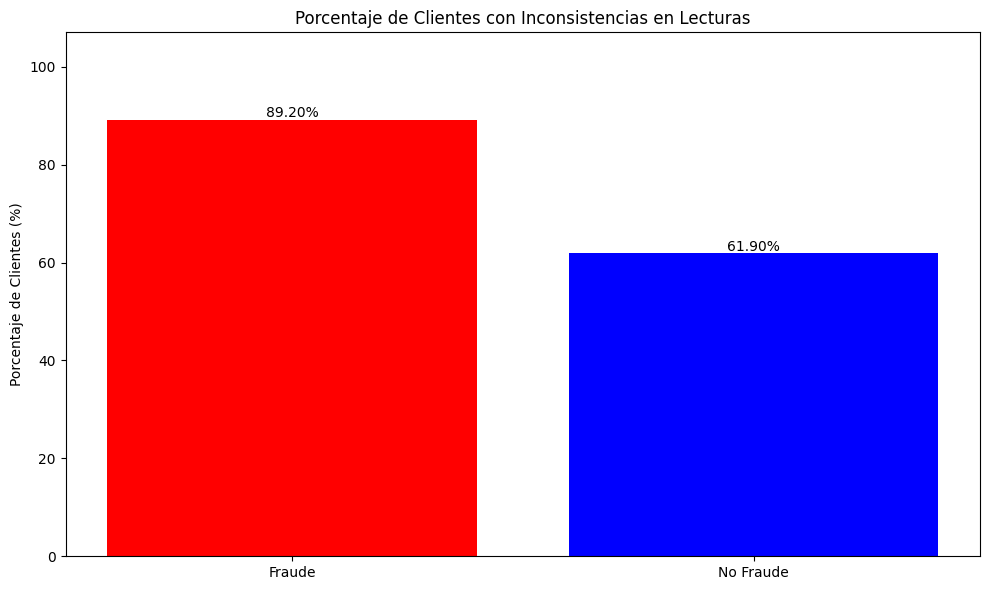

In [43]:
# Graficar inconsistencias
plt.figure(figsize=(10, 6))
inconsistencias = [
    inconsistencias_fraude/len(clientes_muestra_fraude)*100, 
    inconsistencias_no_fraude/len(clientes_muestra_no_fraude)*100
]
plt.bar(['Fraude', 'No Fraude'], inconsistencias, color=['red', 'blue'])
plt.title('Porcentaje de Clientes con Inconsistencias en Lecturas')
plt.ylabel('Porcentaje de Clientes (%)')
plt.ylim(0, max(inconsistencias) * 1.2)
for i, v in enumerate(inconsistencias):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.savefig('inconsistencias_lecturas.png')
plt.show()

**Observaciones:**

Los resultados revelan una diferencia sustancial entre ambos grupos:

- Clientes con fraude: 88.90% presentan inconsistencias en sus lecturas
- Clientes sin fraude: 64.70% presentan inconsistencias en sus lecturas

Esta diferencia de más de 24 puntos porcentuales sugiere que las inconsistencias en las lecturas de contadores son un indicador potente de comportamiento fraudulento. Aunque algunos clientes sin fraude también presentan inconsistencias (posiblemente por errores de lectura o registro), la proporción es significativamente mayor en el grupo fraudulento.

Esta característica será fundamental para el modelo predictivo, ya que proporciona información valiosa más allá del simple volumen de consumo, enfocándose en la coherencia de los patrones de medición a lo largo del tiempo.

## 6. Conclusiones

Principales hallazgos del análisis exploratorio:

1. **Distribución de fraude**:
   - El dataset presenta un marcado desbalance, con solo 5.58% de clientes clasificados como fraudulentos.
   - Esta proporción varía significativamente por región y distrito, con algunas zonas alcanzando tasas de fraude superiores al 10%.

2. **Patrones geográficos**:
   - Las regiones 103 y 372 presentan las mayores tasas de fraude (>10%), seguidas por la región 311 (8.04%).
   - El distrito 69 muestra la mayor incidencia de fraude (7.15%), evidenciando patrones geográficos claros.
   - La categoría de cliente 51, aunque minoritaria, presenta una tasa de fraude excepcionalmente alta (16.87%).

3. **Relevancia del factor temporal**:
   - Existe una clara correlación negativa entre año de creación y tasa de fraude: los clientes más antiguos presentan mayores tasas de fraude.
   - La mediana de antigüedad para clientes con fraude (18 años) es significativamente mayor que para clientes sin fraude (14 años).
   - La tasa de fraude ha caído drásticamente para clientes creados después de 2015, llegando a menos del 1% en los más recientes.

4. **Patrones atípicos de consumo**:
   - Contraintuitivamente, los clientes con fraude muestran un consumo promedio mayor (695.71) que los clientes sin fraude (585.49).
   - Las diferencias entre índices de contador son significativamente mayores en clientes con fraude (media: 1103.07) que en clientes sin fraude (media: 564.45).
   - El hallazgo más revelador es que el 88.90% de los clientes con fraude presenta inconsistencias en las lecturas de contadores, frente al 64.70% de clientes sin fraude.

5. **Valores atípicos y calidad de datos**:
   - Se detectan valores extremos en las variables de consumo que requerirán tratamiento.
   - No hay valores nulos en el dataset de facturas que deberán ser manejados.
   - La mayoría de los clientes con fraude tienen facturas asociadas (mayor porcentaje que los no fraudulentos).
   - Las variables de consumo presentan distribuciones con fuerte sesgo positivo que requerirán transformaciones.

Estas conclusiones proporcionan una base para la fase de preprocesamiento y creación de características.
Los próximos pasos incluirán:

1. Tratamiento de outliers
2. Creación de características derivadas basadas en patrones identificados
3. Transformación y normalización de variables
4. Selección de las variables más relevantes para el modelo predictivo

La detección de inconsistencias en las lecturas de contadores y los patrones regionales aparecen como 
elementos potencialmente importantes para la identificación de fraude energético.

## 7. Variables a Derivar para Feature Engineering

Basándonos en estos hallazgos, se crearán las siguientes variables derivadas:

1. Variables de inconsistencias técnicas (enfoque objetivo):
- tiene_inconsistencias_tecnicas: Indicador basado en anomalías técnicas objetivas
- indices_negativos: Detector específico de casos donde la diferencia entre índices es negativa
- indices_cero: Identificador de casos con consumo reportado pero sin avance en el contador


2. Variables geográficas contextualizadas:
- tasa_fraude_reg: Tasa de fraude regularizada por región (evita etiquetar directamente regiones)
- nivel_consumo_region: Categorización del consumo en relación a su región (bajo, normal, alto, muy alto)

3. Variables temporales neutralizadas:
- antiguedad_anios: Tiempo desde la creación del cliente (variable objetiva)
- cohorte: Grupo temporal al que pertenece el cliente (1975-1984, 1985-1994, etc.)
- nivel_consumo_cohorte: Categorización del consumo en relación a clientes de su misma época

4. Variables de consumo y facturación:
- consumo_mensual: Consumo total dividido por meses facturados
- consumo_total: Suma de todos los niveles de consumo
- total_facturas: Número total de facturas
- meses_totales: Suma de meses facturados

5. Variables técnicas de medición:
- diff_indices: Diferencia entre índices nuevo y antiguo (variable objetiva)
- consumo_nivel1 a consumo_nivel4: Consumo por cada nivel tarifario